In [1]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
import matplotlib as mpl
import networkx as nx
from matplotlib.gridspec import GridSpec
from numpy.fft import fft, ifft

# For using latex formula
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{amsmath,dsfont}')

In [9]:
def make_binary(Rho, threshold):
    Rho_binary=np.zeros(len(Rho))
    for i in np.arange(len(Rho)):
        if (Rho[i]>threshold):
            Rho_binary[i]=1
    return(Rho_binary)

In [2]:
# Function for finding start and end points of the activity cycles
# Input: Rho
# Output: startpoints &  endpoints

def StartAndEndPoints(Rho, precision):
    #precision=1-0.95*max(Rho)  #default = 0.05
    t=np.arange(0,len(Rho))
    tmax=max(t)
    threshold=min(Rho)
    flag=False
    i=0
    startlocs=[]
    endlocs=[]
    while i<(tmax-10):
        if ( Rho[i]-threshold <= precision ):
            i=i+1
            continue
        first=i
        if (Rho[i-1] < Rho[i]):

            first=first-1
            if i==0:
                first=0
        startlocs.append(first)
        flag=True
        while(flag and i<tmax-1):
            i=i+1
            if ( Rho[i]-threshold <= precision ):
                flag=False
        endlocs.append(i)
        i=i+1;
        
    return(startlocs,endlocs)

In [3]:
# Function for finding maximum points of the activity cycles
# Input: startlocs and endlocs
# Output: maxpoints 

def MaxPoints(Rho,startlocs,endlocs):
    maxpoints=[]
    if endlocs==[]:
        return(maxpoints)
    else:
        x=np.arange(len(startlocs))
        for i in x:
            interval=Rho[startlocs[i]:endlocs[i]]
            #m=max(interval)
            maxpoints.append(interval.argmax()+startlocs[i])
        return(maxpoints)

In [4]:
# Function for calculating burst width of a timeseri
# Input: Rho , tmax
# Output: An array including the width of the burst at each time --> y

def BurstWidth(Rho,precision):
    tmax=len(Rho)
    y=np.zeros(len(Rho))
    startlocs , endlocs = StartAndEndPoints(Rho,precision)
    startlocs.append(tmax)
    endlocs.append(tmax)
    if startlocs==[]:
        startlocs.append(0)
    if endlocs==[]:
        endlocs.append(0)
    imax=len(endlocs)-1
    i=0
    smean=9 # mean value of a silence interval
    a=startlocs[0]
    while (i<imax):
        if startlocs[i+1]-endlocs[i] < smean:
            i=i+1
            continue
        else:
            b=endlocs[i]
            c=b-a
            for j in np.arange(a,b):
                y[j] = c
            a=startlocs[i+1]
            i=i+1
    if (a<10):
        if all(v < 0.01 for v in Rho):
            y=np.zeros(len(Rho))
        else:    
            y=np.ones(len(y))
            y[0], y[len(y)-1] = 0, 0
    else:
        ymax=max(y)
        if ymax!=0:
            y=y/ymax
    return(np.array(y))

In [5]:
# Function for calculating Shanon entropy of burst width
# Input: y (The array of burst width)
# Output: hB; the shanon entropy of the bursts for the input --> a not normalized number

def BurstShanon(y):
    y_round=np.round(y, decimals=2)
    l=list(y_round)
    hB=0
    distsB=np.zeros(101)
    for i in np.arange(101):
        distsB[i] = (l.count(i/100))/len(l)
        if (distsB[i]!=0):
            hB = hB - distsB[i] * np.log2(distsB[i])
    return(hB)

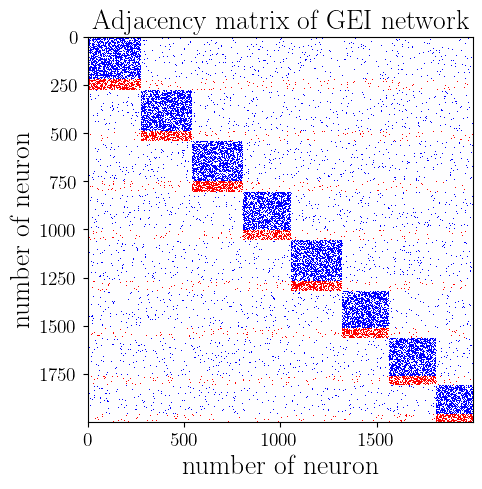

In [6]:
######################################################################################################
# The code creates a modular random network where excitatory and inhibitory neurons 
# have same connection probabilities within blocks, and both excitatory and inhibitory neurons form 
# connections outside their blocks, as specified in the 
#                      "Type GEI: Global-Inhibition" configuration.
######################################################################################################
import numpy as np
import random
import time

# Constants
N = 2000  # Total number of nodes
BLOCK = 8  # Number of blocks
P_IN = 0.6  # Connection probability inside blocks
P_OUT = 0.029  # Connection probability outside blocks
E_PER = 0.8  # Excitatory percentage
W_EXCITATORY = 1  # Weight of excitatory synapses
W_INHIBITORY = -1  # Weight of inhibitory synapses

# Initialize adjacency matrix
A = np.zeros((N, N), dtype=int)
# Main function
def main():
    # Set random seed
    random.seed(time.time())

    N_mean = int(N / BLOCK)  # Mean number of nodes inside blocks
    N_min = int(N_mean - N_mean * 0.1)  # Minimum number of neurons
    N_max = int(N_mean + N_mean * 0.1)  # Maximum number of neurons
    sum_N = 0

    # Process each block
    for b in range(BLOCK):
        if b < BLOCK - 1:
            # Random number of neurons in current block
            new_N = random.randint(N_min, N_max)
        else:
            # Last block takes remaining neurons
            new_N = N - sum_N

        # Create connections
        for i in range(sum_N, sum_N + new_N):
            for j in range(N):
                if i == j:
                    continue
                r = random.random()
                start = int(sum_N + E_PER * new_N)
                if sum_N <= j < sum_N + new_N:  # Inside block
                    if r < P_IN:
                        A[i][j] = W_EXCITATORY if i < start else W_INHIBITORY
                else:  # Outside block
                    if r < P_OUT:
                        A[i][j] = W_EXCITATORY if i < start else W_INHIBITORY

        sum_N += new_N

    # Plotting adjacency matrix
    fs = 20  #font size
    ls = 14  #label size
    Adj_cm = 'bwr_r'  # colormap for adjacency matrix 
    plt.figure(figsize = (5, 5))
    plt.imshow(A, interpolation='nearest', cmap=Adj_cm)
    plt.tick_params(axis='both', labelsize=ls)
    plt.title('Adjacency matrix of GEI network', fontsize=fs)
    plt.xlabel('number of neuron', fontsize=fs)
    plt.ylabel('number of neuron', fontsize=fs)

if __name__ == "__main__":
    main()

In [7]:
# Loading data (active neurons) for the type of GEI 
s0='ActiveExcDensK200T1X150Seri'
s1='ActiveInhDensK200T1X150Seri'
s2='R'
s3='.txt'
s4='DE'
s5='DI'

# just data for eta=1
DE1R10=np.loadtxt('ActiveExcDensK200T1X150Seri1R10.txt')
DI1R10=np.loadtxt('ActiveInhDensK200T1X150Seri1R10.txt')

for i in np.arange(5):
    for j in np.arange(9):
        Ename=s0+str(i+1)+s2+str(j+1)+s3
        Iname=s1+str(i+1)+s2+str(j+1)+s3
        dataNameE=s4+str(i+1)+s2+str(j+1)
        dataNameI=s5+str(i+1)+s2+str(j+1)
        actionE=dataNameE+'=np.loadtxt(Ename)'
        actionI=dataNameI+'=np.loadtxt(Iname)'
        exec(actionE)
        exec(actionI)
t=np.arange(25001)

# making RhoE and RhoI matrices
RhoE=np.zeros([46,25001])
RhoI=np.zeros([46,25001]) 

for i in np.arange(46):
    for j in t:
        if (i<9):
            dataEname='DE5R'+str(i+1)+'['+str(j)+',1:]'
            dataIname='DI5R'+str(i+1)+'['+str(j)+',1:]'
            actionE='RhoE[i,j] = sum('+dataEname+')'
            actionI='RhoI[i,j] = sum('+dataIname+')'
            exec(actionE)
            exec(actionI)
        if (9<=i<=17):
            dataEname='DE4R'+str(i-8)+'['+str(j)+',1:]'
            dataIname='DI4R'+str(i-8)+'['+str(j)+',1:]'
            actionE='RhoE[i,j] = sum('+dataEname+')'
            actionI='RhoI[i,j] = sum('+dataIname+')'
            exec(actionE)
            exec(actionI)
        if (18<=i<=26):
            dataEname='DE3R'+str(i-17)+'['+str(j)+',1:]'
            dataIname='DI3R'+str(i-17)+'['+str(j)+',1:]'
            actionE='RhoE[i,j] = sum('+dataEname+')'
            actionI='RhoI[i,j] = sum('+dataIname+')'
            exec(actionE)
            exec(actionI)
        if (27<=i<=35):
            dataEname='DE2R'+str(i-26)+'['+str(j)+',1:]'
            dataIname='DI2R'+str(i-26)+'['+str(j)+',1:]'
            actionE='RhoE[i,j] = sum('+dataEname+')'
            actionI='RhoI[i,j] = sum('+dataIname+')'
            exec(actionE)
            exec(actionI)
        if (36<=i<=45):
            dataEname='DE1R'+str(i-35)+'['+str(j)+',1:]'
            dataIname='DI1R'+str(i-35)+'['+str(j)+',1:]'
            actionE='RhoE[i,j] = sum('+dataEname+')'
            actionI='RhoI[i,j] = sum('+dataIname+')'
            exec(actionE)
            exec(actionI)

# Rho is a 46*20001 2D matrix where the first row shows \rho as a 
# function of time for Eta=0.00001 (row1 of seri5)
Rho=RhoE+RhoI

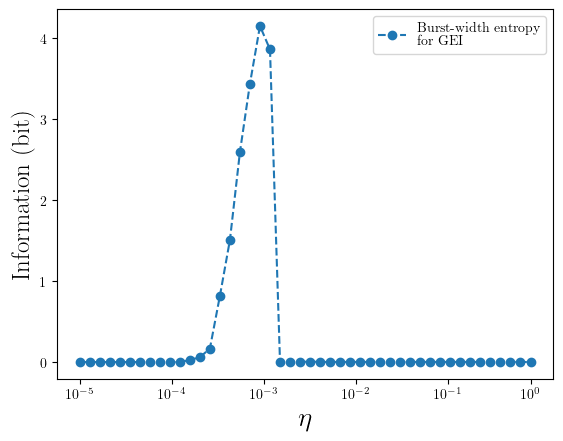

In [11]:
# Calculating Burst-width entropy --> hBGEI
hBGEI=[]
precision=0.005
for i in np.arange(len(Rho)):
    y=BurstWidth(Rho[i,:],precision)
    hBGEI.append(BurstShanon(y))


#Plotting
plt.plot(hBGEI, '--o', label='Burst-width entropy\n\tfor GEI')
plt.xlabel(r'$\eta$', fontsize=20)
plt.ylabel('Information (bit)', fontsize=18)
labels=['$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^0$']
plt.xticks([0, 9.2, 18.4, 27.6, 36.8, 45], labels)
plt.legend()

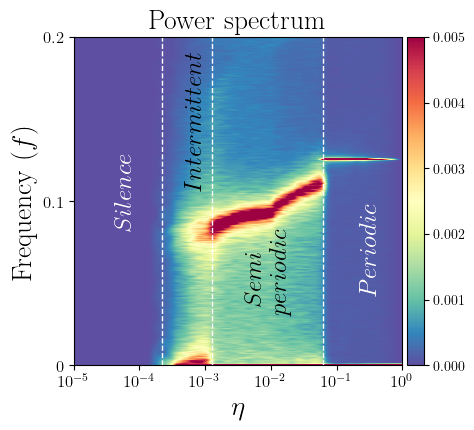

In [13]:
#Power

lag=1000
fftMat=[]
for i in np.arange(0,len(Rho)):
    sig=Rho[i,:]
    t=np.arange(0,len(sig))
    L=len(t[lag:])
    Fs = 1  #sampling frequency
    Y=fft(sig[lag:])
    P2 = np.abs(Y/L)
    P1 = P2[0:int(L/2)+1]
    end=len(P1)-1
    P1[1:end] = 2*P1[1:end]
    x=np.arange(0,(int(L/2)+1))
    f = Fs*x/L
    fftMat.append(P1)  

fftMat=np.rot90(fftMat)
fftMat=np.flipud(fftMat)

exMat=fftMat[:4800]
colormap='Spectral_r'

fig, axes = plt.subplots(figsize=(5,5))

ax1= plt.subplot()
im=ax1.imshow(exMat, cmap=colormap, vmin=0, vmax=0.005, interpolation = "gaussian", extent=[0,1,0,1], origin='lower')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
#plt.title('Threshold = 4')
plt.ylabel('Frequency~($f$)', fontsize=20)
#ax1.set_yticks([0, .25, .5, .75, 1])
#ax1.set_yticklabels([0, 0.125, 0.25, 0.375, 0.5])
ax1.set_yticks([0, .5, 1])
ax1.set_yticklabels(['0', '0.1', '0.2'])
ax1.set_xticks([0, .2, .4, .6, .8, 1])
ax1.set_xticklabels(['$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^0$'])
plt.xlabel(r'$\eta$', fontsize=20)
plt.plot([0.76,0.76],[0,1], '--', linewidth = 1, color='white')
plt.plot([0.42,0.42],[0,1], '--', linewidth = 1, color='white')
plt.plot([0.27,0.27],[0,1], '--', linewidth = 1, color='white')
plt.title('Power~spectrum',fontsize=20)

from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
#cbar.set_label('Power~spectrum',fontsize=20, rotation=90)

plt.figtext(0.72, 0.32, '$Periodic$', fontsize=18, fontweight='bold', color='white', rotation=90)
plt.figtext(0.49, 0.3, '$Semi$', fontsize=18, fontweight='bold', color='black', rotation=90)
plt.figtext(0.54, 0.28, '$periodic$', fontsize=18, fontweight='bold', color='black', rotation=90)
plt.figtext(0.37, 0.53, '$Intermittent$', fontsize=18, fontweight='bold', color='black', rotation=90)
plt.figtext(0.23, 0.45, '$Silence$', fontsize=18, fontweight='bold', color='white', rotation=90)

plt.subplots_adjust(top=0.98, bottom=0.02, left=0.15, right=0.85)#, hspace=0.1,wspace=.1)

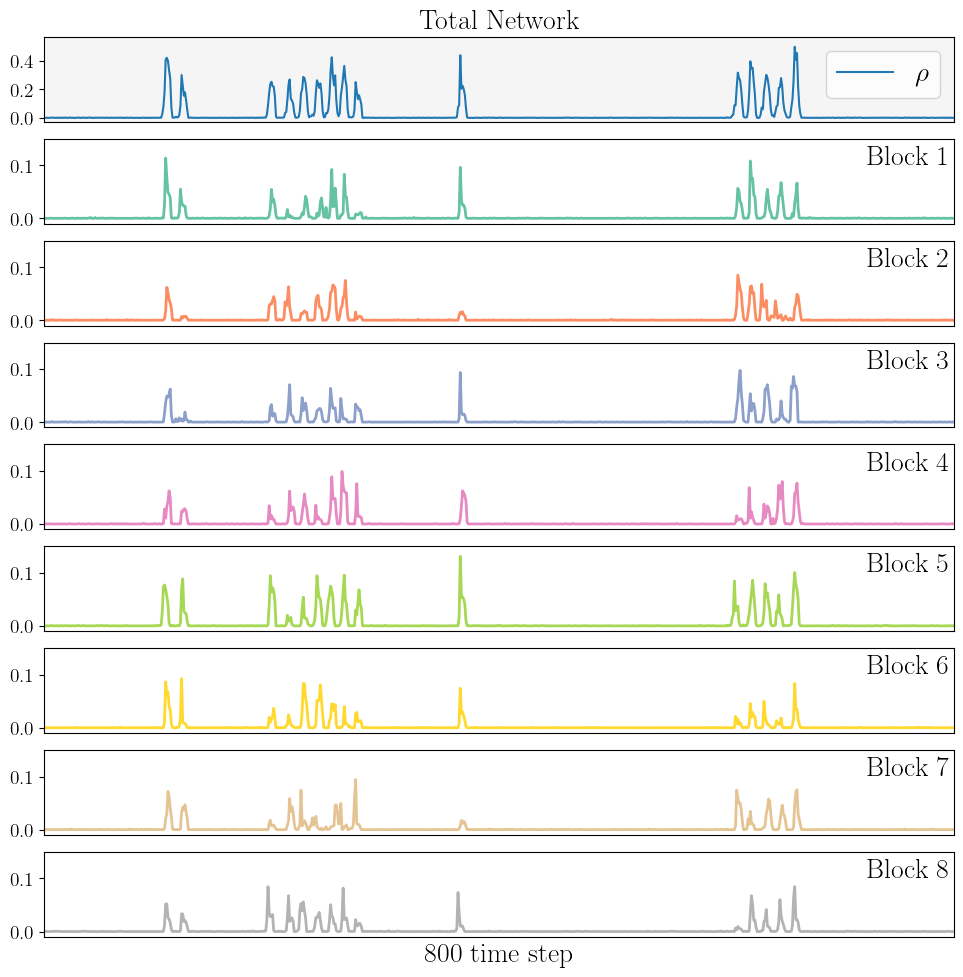

In [18]:


seri=4  # between 1 to 5
r=8     # between 1 to 9     

f=20

n = 8
colors = plt.cm.Set2(np.linspace(0,1,n))

left=14100
right=14900

#plot
from matplotlib.gridspec import GridSpec
fig=plt.figure(figsize=(10,10),facecolor='white')
gs=GridSpec(9,1)


E=np.zeros(25001, dtype = float)
I=np.zeros(25001, dtype = float)
b=1
for i in np.arange(1,9):
    actionE='RE=DE'+str(seri)+'R'+str(r)+'[:,'+str(b)+']'
    exec(actionE)
    actionI='RI=DI'+str(seri)+'R'+str(r)+'[:,'+str(b)+']'
    exec(actionI)
    E=E+RE  # for making total E for the last plot
    I=I+RI  # for making total I for the last plot
    ax = fig.add_subplot(gs[i])
    col='C'+str(i)
    plt.plot(t,RE+RI,color=colors[i-1], lw=2)  # Notice tha we plot just RE+RI not E+I
    plt.ylim(-0.01,0.15)
    plt.yticks(fontsize=14)
    plt.xlim(left,right)
    plt.gca().set_xticks([])
    name='Block ' + str(b)
    ax.text(.95,.7,name, fontsize=f,
        horizontalalignment='center',
        transform=ax.transAxes)
    #plt.title(name, fontsize=f) 
    b = b+1
plt.xlabel(str(right-left)+'~time step', fontsize=f)
plt.xticks(fontsize=14)

ax1=fig.add_subplot(gs[0], facecolor='whitesmoke')
plt.plot(t,E+I, label=r'$\rho$')
plt.legend(fontsize=f)
plt.title('Total Network', fontsize=f)
plt.xlim(left,right)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().set_xticks([])


plt.subplots_adjust(top=0.95, bottom=0.05, left=0.06, right=0.97, hspace=0.2,wspace=.35)

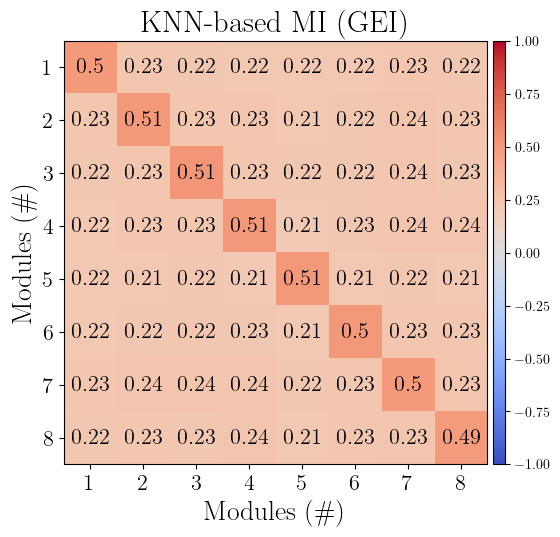

In [15]:
# Plotting the KNN mutual information matrix

from sklearn.metrics import mutual_info_score
from sklearn.neighbors import NearestNeighbors

def knn_mutual_information(x, y, k=3):
    # Stack the two time series
    data = np.vstack((x, y)).T
    
    # Fit KNN
    nbrs = NearestNeighbors(n_neighbors=k).fit(data)
    distances, indices = nbrs.kneighbors(data)
    
    # Calculate MI
    mi = mutual_info_score(None, None, contingency=np.histogram2d(x[indices.flatten()], y[indices.flatten()])[0])
    return mi


# Set seri and row >> Default: seri=4 and row=8
fs=22
threshold=0.005
coff=3.7
seri=4
row=8

KNNmiMatrix=np.zeros((8,8))
for i in np.arange(8):
    action='sig1 = DE'+str(seri)+'R'+str(row)+'[:,'+str(i+1)+'] + DI'+str(seri)+'R'+str(row)+'[:,'+str(i+1)+']'
    exec(action)
    sig1=coff*sig1
    sig1 = make_binary(sig1,threshold)
    for j in np.arange(8):
        action='sig2 = DE'+str(seri)+'R'+str(row)+'[:,'+str(j+1)+'] + DI'+str(seri)+'R'+str(row)+'[:,'+str(j+1)+']'
        exec(action)
        sig2=coff*sig2 
        sig2 = make_binary(sig2,threshold)
        cosineSimilarity = knn_mutual_information(sig1,sig2)
        KNNmiMatrix[i,j] = cosineSimilarity

fig, ax = plt.subplots(figsize=(6,5.5))
im=plt.imshow(KNNmiMatrix, interpolation='nearest', cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(fontsize=fs-6)
plt.yticks(fontsize=fs-6)  
plt.title('KNN-based MI (GEI)', fontsize=fs) 
plt.xlabel('Modules '+ r'$(\#)$', fontsize=fs-2)
plt.ylabel('Modules '+ r'$(\#)$', fontsize=fs-2)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)
#cbar=plt.colorbar(label=r'$CS$')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8'])
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7])
ax.set_yticklabels(['1', '2', '3', '4', '5', '6', '7', '8'])

# Loop over data dimensions and create text annotations.
for i in np.arange(8):
    for j in np.arange(8):
        text = ax.text(j, i, np.round(KNNmiMatrix[i, j],2),
                       ha="center", va="center", color="k", fontsize=fs-6)


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(0, -1.0, '$\\mathdefault{−1}$'),
  Text(0, 0.0, '$\\mathdefault{0}$'),
  Text(0, 1.0, '$\\mathdefault{1}$'),
  Text(0, 2.0, '$\\mathdefault{2}$'),
  Text(0, 3.0, '$\\mathdefault{3}$'),
  Text(0, 4.0, '$\\mathdefault{4}$'),
  Text(0, 5.0, '$\\mathdefault{5}$'),
  Text(0, 6.0, '$\\mathdefault{6}$')])

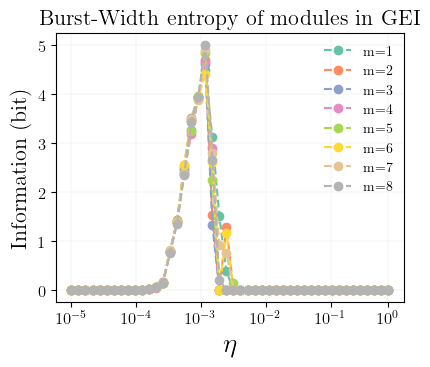

In [16]:
# Plotting burst-entropy of modules
# making entropy; a 8in46 matrix that hB(i,j) 
# denotes the Burst entropy of block i when eta=j.

threshold=0.005
precision=0.005
coff=3.7

hBb=np.zeros((8,46))

# for seri 5
col=0
for r in np.arange(1,10):
    for b in np.arange(1,9):
        action='DDD = DE5R' + str(r) +'[:,'+str(b)+'] + DI5R' +str(r) +'[:,'+str(b)+']'
        exec(action)
        DDD = coff*DDD
        y=BurstWidth(DDD,precision)
        hBb[b-1,r-1+col] = BurstShanon(y)

# for seri 4
col=9
for r in np.arange(1,10):
    for b in np.arange(1,9):
        action='DDD = DE4R' + str(r) +'[:,'+str(b)+'] + DI4R' +str(r) +'[:,'+str(b)+']'
        exec(action)
        DDD=coff*DDD
        y=BurstWidth(DDD,precision)
        hBb[b-1,r-1+col] = BurstShanon(y)

# for seri 3
col=18
for r in np.arange(1,10):
    for b in np.arange(1,9):
        action='DDD = DE3R' + str(r) +'[:,'+str(b)+'] + DI3R' +str(r) +'[:,'+str(b)+']'
        exec(action)
        DDD=coff*DDD
        y=BurstWidth(DDD,precision)
        hBb[b-1,r-1+col] = BurstShanon(y)

# for seri 2
col=27
for r in np.arange(1,10):
    for b in np.arange(1,9):
        action='DDD = DE2R' + str(r) +'[:,'+str(b)+'] + DI2R' +str(r) +'[:,'+str(b)+']'
        exec(action)
        DDD=coff*DDD
        y=BurstWidth(DDD,precision)
        hBb[b-1,r-1+col] = BurstShanon(y)

# for seri 1
col=36
for r in np.arange(1,10):
    for b in np.arange(1,9):
        action='DDD = DE1R' + str(r) +'[:,'+str(b)+'] + DI1R' +str(r) +'[:,'+str(b)+']'
        exec(action)
        DDD=coff*DDD
        y=BurstWidth(DDD,precision)
        hBb[b-1,r-1+col] = BurstShanon(y)

fs=16 #font size

n = 8
colors = plt.cm.Set2(np.linspace(0,1,n))
plt.figure(figsize=(4.5,3.5))

for b in np.arange(0,8):
    plt.plot(hBb[b,:], '--.', color=colors[b], label='m='+str(b+1), markersize=12)
plt.legend(frameon=False, fontsize=fs-6)
plt.title('Burst-Width entropy of modules in GEI', fontsize=fs)
labels=['$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^0$']
plt.xticks([0, 9.2, 18.4, 27.6, 36.8, 45], labels)
plt.grid(':', lw=0.3, alpha=0.2, color='C7')
plt.ylabel('Information (bit)', fontsize=fs)
plt.xlabel(r'$\eta$', fontsize=fs+4)
plt.xticks(fontsize=fs-4)
plt.yticks(fontsize=fs-4)